In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

ROOT_DIR = Path('..')

# import DataLoader as DataLoader
# reload(DataLoader)

# dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

## Modeling Training

## LSTM

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df_final.DIAGNOSIS = df_final.DIAGNOSIS.fillna('')
max_features = 4848

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df_final.DIAGNOSIS))
df_result = tokenizer.texts_to_sequences(df_final.DIAGNOSIS)
df_result = pad_sequences(df_result, maxlen=25)
df_final['EMB_CODED'] = [x for x in df_result]

In [3]:
# t0_df = pd.read_csv(df_final)
path_t0_df = ROOT_DIR / 'data/output_csv/sequence_t4_v2.csv'  
t0_df = pd.read_csv(path_t0_df)# t0_df
temp = t0_df.groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: len(x)).reset_index(name = 'count')
temp.count = temp['count'].astype(int)
admission_t0 = t0_df[~t0_df.HADM_ID.isin(temp[temp.count < 4]['HADM_ID'])][['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])
# t0_df = t0_df.drop(columns=["SUBJECT_ID", "HADM_ID", 'level_3'])

X_t0_train, X_t0_test, y_t0_train, y_t0_test = train_test_split(
    admission_t0.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    admission_t0['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=admission_t0['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)
X_t0_train = t0_df.merge(X_t0_train[['SUBJECT_ID', 'HADM_ID']])
y_t0_train = X_t0_train.IS_SEPSIS
X_t0_train = X_t0_train.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS'])
X_t0_test = t0_df.merge(X_t0_test[['SUBJECT_ID', 'HADM_ID']])
y_t0_test = X_t0_test.IS_SEPSIS
X_t0_test = X_t0_test.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS'])
# # If you want to get the train and test set as dataframes:
train_t0_df = pd.concat([X_t0_train, y_t0_train], axis=1)
test_t0_df = pd.concat([X_t0_test, y_t0_test], axis=1)

In [4]:
# Feature scaling - Standardisation
scaler = StandardScaler()

X_t0_train = scaler.fit_transform(X_t0_train)
X_t0_test = scaler.transform(X_t0_test)

In [5]:
def ts_to_secs(X, Y, w, s, **options):

    ## We want the Rows of matrices show each Feature and the Columns show time points.
    X = X.T

    m = X.shape[0]   # Data Dimension
    ttp = X.shape[1] # Total Time Points
    number_of_secs = int(round(((ttp - w)/s)))

    ##  Create a 3D matrix for Storing Sections
    secs_data = np.zeros((number_of_secs , m , w ))
    # act_secs_labels = np.zeros(number_of_secs)
    act_secs_labels = []
    k=0
    for i in range(0 , ttp-w, s):
        secs_data[k] = X[:, i:i+w]
        # act_secs_labels[k] = y_t0_train.reset_index().iloc[0].IS_SEPSIS.astype(int)
        sub_act = [0, 0]
        true_index = Y[i].astype(int)
        sub_act[true_index] = 1
        act_secs_labels.append(sub_act)
        k = k+1

    secs_data = secs_data[0:k]
    act_secs_labels = np.array(act_secs_labels[0:k])
    return secs_data, act_secs_labels


In [6]:
def data_preparation(w, s):
  ## This Variable Defines the Size of Sliding Window
  ## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor)
  # w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
  ## Here We Choose Step Size for Building Different Snapshots from Time-Series Data
  ## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
  # s = 10
  train_data, act_train = ts_to_secs(X_t0_train, y_t0_train,
                                      w,
                                      s)

  # s = 10
  test_data, act_test = ts_to_secs(X_t0_test, y_t0_test,
                                      w,
                                      s)


  ## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  train_data = np.expand_dims(train_data,axis=3)
  print("[INFO] -- Shape of Training Sections:", train_data.shape)
  test_data = np.expand_dims(test_data,axis=3)
  print("[INFO] -- Shape of Test Sections:", test_data.shape)

  return train_data, act_train, test_data, act_test

In [7]:
train_data, act_train, test_data, act_test = data_preparation(w=4, s=4)
act_label = ['NON-SEPSIS', 'SEPSIS']

[INFO] -- Shape of Training Sections: (36931, 32, 4, 1)
[INFO] -- Shape of Test Sections: (9232, 32, 4, 1)


In [8]:
new_train_data = train_data.reshape(36931, 32, 4)
new_train_data.shape

(36931, 32, 4)

In [9]:
new_test_data = test_data.reshape(9232, 32, 4)
new_test_data.shape

(9232, 32, 4)

In [35]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import tensorflow as tf
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

def LSTM_model():
    d = 0.25
    model=Sequential()
    # model.add(Embedding(emb_table.shape[0], emb_table.shape[1], input_length=25, weights = [emb_table]))
    # model.add(Embedding(emb_table.shape[0], emb_table.shape[1], input_length=25))
    model.add(LSTM(4,return_sequences=True,input_shape=(32,4)))
    model.add(Dropout(d))
    model.add(LSTM(2,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(75))
    model.add(Dropout(d))
    model.add(Dense(25))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 32, 4)             144       
                                                                 
 dropout_16 (Dropout)        (None, 32, 4)             0         
                                                                 
 lstm_13 (LSTM)              (None, 32, 2)             56        
                                                                 
 dropout_17 (Dropout)        (None, 32, 2)             0         
                                                                 
 lstm_14 (LSTM)              (None, 75)                23400     
                                                                 
 dropout_18 (Dropout)        (None, 75)                0         
                                                                 
 dense_8 (Dense)             (None, 25)               

In [19]:
def get_class_weights():
  label_counts = y_t0_train.value_counts()
  label_proportions = label_counts / len(y_t0_train)*100
  # Calculate class weights
  class_weights = {0: 1 / (label_proportions[0] / 100), 1: 1 / (label_proportions[1] / 100)}

  # Round the class weights to the desired precision (optional)
  class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}
  return class_weights

get_class_weights()

{0: 1.1207, 1: 9.2841}

In [37]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', save_best_only = True, monitor='mse', mode='min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', patience = 20)
callbacks_list = [early_stop, checkpointer]
m = model.fit(new_train_data, act_train, 
              class_weight=get_class_weights(),
              epochs=50, batch_size=64, verbose=1,
               callbacks=callbacks_list)

Epoch 1/50
578/578 [==============================] - 16s 27ms/step - loss: 0.4724 - mse: 0.2367
Epoch 2/50
  3/578 [..............................] - ETA: 16s - loss: 0.4465 - mse: 0.2784

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


578/578 [==============================] - 19s 34ms/step - loss: 0.4540 - mse: 0.2315
Epoch 3/50
578/578 [==============================] - 29s 50ms/step - loss: 0.4485 - mse: 0.2266
Epoch 4/50
578/578 [==============================] - 36s 62ms/step - loss: 0.4410 - mse: 0.2242
Epoch 5/50
578/578 [==============================] - 32s 55ms/step - loss: 0.4350 - mse: 0.2211
Epoch 6/50
578/578 [==============================] - 19s 32ms/step - loss: 0.4338 - mse: 0.2196
Epoch 7/50
578/578 [==============================] - 19s 34ms/step - loss: 0.4312 - mse: 0.2189
Epoch 8/50
578/578 [==============================] - 19s 32ms/step - loss: 0.4289 - mse: 0.2168
Epoch 9/50
578/578 [==============================] - 19s 33ms/step - loss: 0.4276 - mse: 0.2171
Epoch 10/50
578/578 [==============================] - 19s 33ms/step - loss: 0.4235 - mse: 0.2159
Epoch 11/50
578/578 [==============================] - 23s 39ms/step - loss: 0.4239 - mse: 0.2128
Epoch 12/50
578/578 [==================

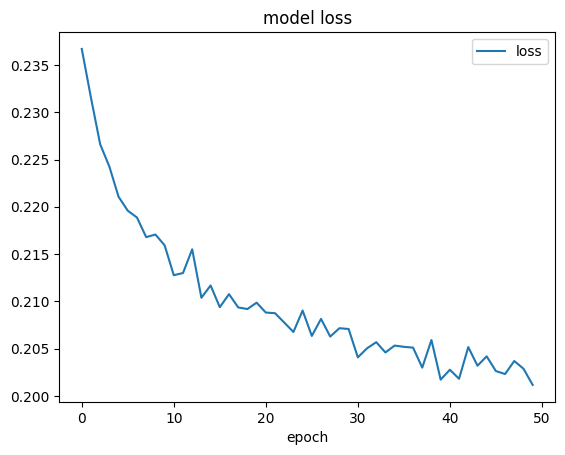

In [39]:
import matplotlib.pyplot as plt
# plt.plot(m.history['loss'])
plt.plot(m.history['mse'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','mse'], loc='upper right')
plt.show()

In [ ]:
# print("Inference:")
# from keras.models import load_model
# eval_act = load_model("weights_best.hdf5")
# X = new_test_data
# Y = act_test
# print_results(eval_act, X, Y)

In [41]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

289/289 [==============================] - 2s 6ms/step
AUC = 0.7710


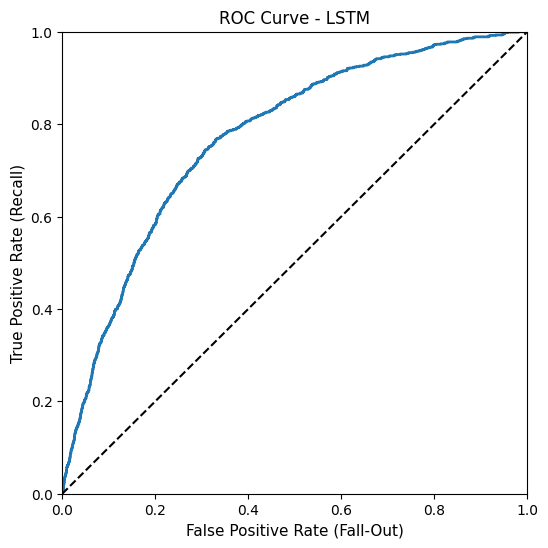

In [48]:
# Predict the test set using the best random forest regressor
y_pred = model.predict(new_test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(act_test, axis=1), y_pred[:, 1], pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

In [71]:
def print_results(M, X_train, Y_train, X_test, Y_test):
    # np.set_printoptions(suppress=True)
    # result1 = M.evaluate(X, Y, verbose = 2)
    # act_acc = np.round(result1[1]*100,2)
    # print("***[RESULT]*** ACT Accuracy: "+str(act_acc))

    preds_train = M.predict(X_train)
    preds_train = np.argmax(preds_train, axis=1)
    conf_mat_train = confusion_matrix(np.argmax(Y_train, axis=1), preds_train)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    preds_test = M.predict(X_test)
    preds_test = np.argmax(preds_test, axis=1)
    conf_mat_test = confusion_matrix(np.argmax(Y_test, axis=1), preds_test)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    print("***[RESULT]*** ACT  Confusion Matrix")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(conf_mat_train, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(conf_mat_test, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
    
    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    f1act = f1_score(np.argmax(Y_test, axis=1), preds_test, average=None).mean()
    print("***[RESULT]*** Test F-1 Score : "+str(f1act*100))
    b_acc = balanced_accuracy_score(np.argmax(Y_test, axis=1), preds_test)
    print("***[RESULT]*** Test Balanced Accuracy Score : "+str(b_acc*100))

289/289 [==============================] - 2s 5ms/step
***[RESULT]*** ACT  Confusion Matrix


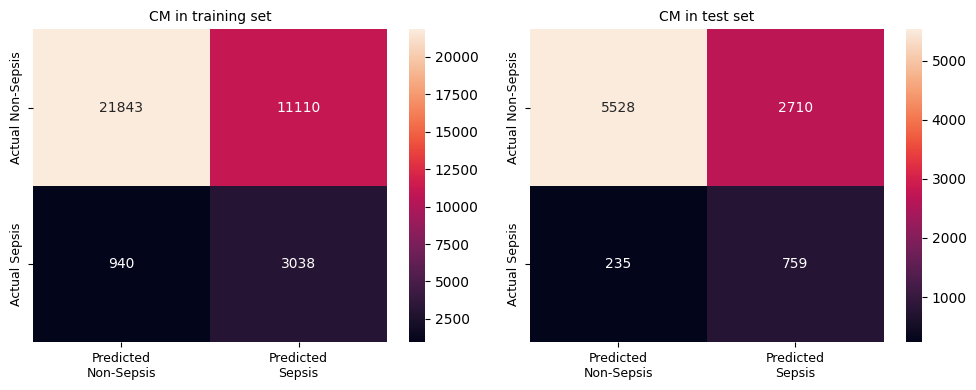

***[RESULT]*** F-1 Score : 56.48939195038132
***[RESULT]*** Balanced Accuracy Score : 71.73090741584735


In [72]:
print_results(model, new_train_data, act_train, new_test_data, act_test)

In [ ]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import tensorflow as tf
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

def LSTM_model():
    d = 0.25
    model=Sequential()
    # model.add(Embedding(emb_table.shape[0], emb_table.shape[1], input_length=25, weights = [emb_table]))
    # model.add(Embedding(emb_table.shape[0], emb_table.shape[1], input_length=25))
    model.add(LSTM(4,return_sequences=True,input_shape=(32,4)))
    model.add(Dropout(d))
    model.add(LSTM(2,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(75))
    model.add(Dropout(d))
    model.add(Dense(25))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])